# Generate Synthetic Data Models and Contributions
---
**Author**: Chris Meyer, PhD; Center for Translational Data Science at the University of Chicago; July 2025

**Overview**: This notebook builds synthetic data models based on a set of input data models, and then it creates several synthetic data contributions consisting of a collection of TSVs and a simple data dictionary for those TSVs. 

**Input**: 27 real, biomedical data models that were obtained from Gen3 data commons APIs.

**Output**: _n_ synthetic data models and a collection of synthetic data contributions based on those synthetic models. The number of contributions depends on the parameters used in the synthetic data contribution script, but essentially, subsets of nodes from each synthetic data model are chosen and then headers are grouped into TSVs using an algorithm that flattens the model below each branching point. In a totally linear model, all headers and foreign keys are flattened into a single TSV. In a highly-branched model, many TSVs will be produced. A file manifest TSV is also created for each file node, which mimics real-world data contributions.



## Pseudocode for synthetic data model generation:
1. Obtain the real Gen3 data model schema.json files from Gen3 APIs. (Currently, fetching 27). Note: The 27 used in this demo are already retrieved and packaged with this notebook.
2. Define run parameters:
    1. min_add_node_rounds (int, default: 6): the minimum number of times to sample nodes from the input data models.
    2. max_add_node_rounds (int, default: 15): the maximum number of times to sample nodes from the input data models.
    3. n (int, default: 10000): the number of data models to generate
    4. input_schemas (list of filenames): the list of data model schemas that will serve as the pool of data models from which to sample nodes/properties.  Note: in the 21 input, real Gen3 data models, there are on average ~26 nodes and ~17 properties per node.
    5. min_props_perc (float, default: 0.25): the minimum percentage of optional properties to keep.
    6. max_props_perc (float, default: 0.75): the maximum percentage of optional properties to keep.

3. Read in the real Gen3 data model schema.json files listed in input_schemas.
4. Compile a master “root node”, which in this case is based on the “project” node in Gen3. This master “project” node contains all properties from all “project” nodes across all Gen3 data models. Every Gen3 data model has a project node. It simply serves the purpose of having a root node to connect all the variable nodes to in the SDMs.
5. Produce a master set of input nodes, excluding Gen3 system / root nodes. Note: The current node pool for 21 Gen3 data models is 237 nodes; this is one place where we could improve synthetic data model diversity, e.g., by bringing in additional (non)-Gen3 data models.
6. Do the following _n_ number of times to generate individual SDMs.
7. Select a random integer add_node_rounds between the min_ / max_add_node_rounds parameters, which will be the number of times to sample nodes from the master set of input nodes; defaults are 6 (min) to 15 (max) rounds to generate SDMs that have ~25-30 total nodes.
8. For add_node_rounds (int) number of times:
    1. From the master pool of nodes from real input models, get the set of nodes not already present in the SDM being created. 
    2. Choose a random node from that set of nodes.
    3. Randomly select an input data model from the set of input data models that contain the randomly selected node.
    4. Find the path from the selected node up to the root node, i.e., the set of parent nodes leading from the selected node up to the project node.
    5. For the selected node and all other nodes in its path up to the root node that are not already in the SDM, build a simplified node definition and add it to the SDM’s list of nodes.
        1. Simplified node definitions include the node name, description, links, and a list of properties.
        2. The list of properties includes all properties listed as “required” in the input data model as well as all other “optional” properties, a node “id” property (e.g., “sample.id” for the sample node), and a property for each link (e.g., “subject.id” for the link from the “sample” node to the “subject” node).
        3. Anything specific only to the Gen3 software, like system properties, is removed.
        4. A random integer num_props is selected that falls between the number of properties in the model multiplied by min_props_perc and max_props_perc. This is the number of optional properties to include in the node’s properties list.
        5. num_props properties are randomly selected from the original node’s list of optional properties to include in the SDM node’s properties list. By default, this results in a random selection of between 25-75% of the node’s original properties to be included in the SDM.
10. Synonymous nodes that exist in the SDM node list are now merged into a randomly chosen synonymous node name.
    1. First, synonymous nodes are found. These are nodes that occupy the same space in the model and serve the same function. Currently, these are the only synonyms being used for this: ['study', 'dataset', 'clinical_trial', 'collection', 'research'] and ['subject', 'patient', 'case', 'participant'].
    2. If synonymous nodes are found in the SDM after adding nodes, a single synonym is randomly chosen (e.g., choose “dataset” if both “study” and “dataset” exist in the SDM) and the synonymous nodes are merged.
    3. Links and properties of all nodes are updated to reflect the chosen synonym. 
11. The SDM is written to a file.


## Import Python packages

In [3]:
import sys
import os
import shutil
import json
import copy
import random
from datetime import datetime
from pathlib import Path
import glob
import pandas as pd
import uuid
from sdm_utils import *

## Define main variables

In [4]:
## Set the following directory paths
home_dir = "/Users/cgmeyer" # your local home directory
git_dir = f"{home_dir}/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools"
nb_dir = f"{git_dir}/notebooks/synthetic_data_contributions" # notebook working directory
schema_dir = f"{nb_dir}/simplified_gen3_schemas" # directory containing input data model schemas

# Note: real Gen3 dms have an average of 35.25 nodes 
# min/max_add_node rounds are 6, 15 for generating close to that average number of nodes per model
min_add_node_rounds = 6
max_add_node_rounds = 15

n=10000
n=10
min_props_perc = 50 # percentage of properties to keep at minimum
max_props_perc = 100 # max percentage of properties to keep


In [5]:
# create output dir
date = datetime.datetime.now().strftime("%Y%m%d")
sdm_dir = f"{nb_dir}/SDM/SDMs_nodes{min_add_node_rounds}-{max_add_node_rounds}_props{min_props_perc}-{max_props_perc}_{date}"
Path(sdm_dir).mkdir(parents=True, exist_ok=True)
print(f"{n} synthetic Data Models will be output to: \n{sdm_dir}.")


10 synthetic Data Models will be output to: 
/Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718.


In [6]:
# create a dictionary to keep track of statistics and information about the synthetic data models
sdms = {}
sdms['max_add_node_rounds'] = max_add_node_rounds
sdms['min_add_node_rounds'] = min_add_node_rounds
sdms['min_props_perc'] = min_props_perc
sdms['max_props_perc'] = max_props_perc
sdms['date'] = date
sdms['out_dir'] = sdm_dir
node_counts = {} # a dictionary of all nodes across all input data models and their counts
prop_counts = {} # a dictionary of all properties across all input data models and their counts



## Read in simple data model schemas
---
In order to be agnostic to the exact structure of the input/output data models, the following code expects input data models to be in this structure and will generate output synthetic models in this format as well, which can then be converted to other formats (graph, relational, linkML, Gen3, etc.):
```
{
  "nodes": [
    {
      "name": "<node_name>",
      "description": "The description of this node.",
      "links": [<a list of node names that this node links to>],
      "required": [<a list of properties that are required (vs. optional)>],
      "properties": [
        {
          "name": "<property name>",
          "description": "The description of this property.",
          "type": "<the data type of this property, e.g., string, integer/number, enumeration, array, etc.>"
        },
        ...
      ]
    }
}
```


In [7]:
# Read in a list of simple data model schemas
#schema_dir = f"{home_dir}/Documents/Notes/AI/AI_data_curation/input_schemas/gen3_schemas/simplified_gen3_schemas_2025-04-23"
schemas = sorted([f"{schema_dir}/{f}" for f in os.listdir(schema_dir) if f.endswith('__jsonschema_dd.json')])
sdms['input_schemas'] = schemas # a list of input data model schema files
dms = read_schemas(schemas) # average node count for the 20 real Gen3 dds  = 35.25



	aids.diseasedatahub.org: 38 nodes with ~24 properties per node.
	bihstaging.data-commons.org: 23 nodes with ~25 properties per node.
	caninedc.org: 47 nodes with ~14 properties per node.
	chicagoland.pandemicresponsecommons.org: 37 nodes with ~31 properties per node.
	chordshealth.org: 8 nodes with ~26 properties per node.
	data.bloodpac.org: 43 nodes with ~13 properties per node.
	data.midrc.org: 25 nodes with ~19 properties per node.
	diseasedatahub.org: 7 nodes with ~20 properties per node.
	flu.diseasedatahub.org: 50 nodes with ~23 properties per node.
	gen3.biodatacatalyst.nhlbi.nih.gov: 33 nodes with ~15 properties per node.
	gen3.datacommons.io: 30 nodes with ~39 properties per node.
	genomel: 19 nodes with ~10 properties per node.
	healdata.org: 3 nodes with ~14 properties per node.
	hnc: 17 nodes with ~28 properties per node.
	ibdgc: 36 nodes with ~13 properties per node.
	icgc.bionimbus.org: 14 nodes with ~26 properties per node.
	jcoin.datacommons.io: 8 nodes with ~6 proper

In [8]:
## If not using the example schemas provided in this demo (the 27 simplified_gen3_schemas), then uncomment lines in this cell
# # write input data model schemas to the output dir in a subdir named "input_schemas" as a reference
# input_schemas_dir = f"{sdm_dir}/input_schemas"
# #!rm -r $input_schemas_dir
# Path(input_schemas_dir).mkdir(parents=True, exist_ok=True)
# for dm in schemas:
#     shutil.copy(dm,input_schemas_dir)



In [9]:
# Keep track of node and property counts for each output synthetic data model generated 
all_nodes = get_node_set(dms,{'nodes':[]})
node_counts = {n:0 for n in all_nodes}
all_props = get_prop_set(dms)
prop_counts = {p:0 for p in all_props}


## Create _n_ synthetic data models

In [13]:
# Create n synthetic data models with the project node as the root node.
sdms['models'] = {}
for i in range(0,n):
    sdms['models'][i] = {} # for tracking
    sdm = {} # the new synthetic data model being built
    sdm['nodes'] = []
    proj_def = create_master_project(dms)
    sdm['nodes'].append(proj_def)
    # A node name is randomly sampled from the set of node names from the input Gen3 data models.
    # This is done a random number of times to build a synthetic data model. (~6 to 15 rounds)
    add_node_rounds = random.randint(min_add_node_rounds,max_add_node_rounds)
    sdms['models'][i]['add_node_rounds'] = add_node_rounds # tracking
    sdms['models'][i]['nodes'] = {} # tracking
    for j in range(0,add_node_rounds):
        node_set = get_node_set(dms,sdm)
        random_node = random.sample(sorted(node_set),1)[0]
        sdms['models'][i]['nodes'][random_node] = {} # tracking
        node_dms = get_node_dms(random_node,dms)
        # pick a random dm from the list of dms that contain the random node
        random_dm_name = random.sample(list(node_dms),1)[0]
        sdms['models'][i]['nodes'][random_node]['dm_name'] = random_dm_name
        random_dm = node_dms[random_dm_name]
        node_def = [n for n in random_dm['nodes'] if n['name'] == random_node][0]
        sdm['nodes'].append(node_def)
        #print(f"\t({j+1}/{add_node_rounds}) Adding node: '{random_node}' from data model: '{random_dm_name}'")
        # Get a random node path from the selected node up to the project node and add that path to SDM.
        random_node_path = get_random_path(random_node,random_dm)
        sdms['models'][i]['nodes'][random_node]['path'] = random_node_path
        # get path nodes not already in sdm
        parent_nodes = [n for n in random_node_path if n not in [n['name'] for n in sdm['nodes']]]
        sdms['models'][i]['nodes'][random_node]['parent_nodes'] = parent_nodes
        #print(f"\t\tAdding parent nodes: {parent_nodes}")
        for parent_node in parent_nodes:
            node_def = [n for n in random_dm['nodes'] if n['name'] == parent_node][0]
            sdm['nodes'].append(node_def)
            #print(f"\t\tAdding node: {parent_node} from data model: '{random_dm_name}'.")
        sdm = fix_links(sdm) # fix links for the new nodes added to the sdm

    # If there are any synonyms, pick one and merge into the chosen name
    odm = copy.deepcopy(sdm) # troubleshooting
    syn_lists = get_sdm_synonyms(sdm)
    sdms['models'][i]['synonyms'] = syn_lists
    sdm = update_sdm_synonyms(sdm,syn_lists)

    # # FIX LINKS bc chose random paths (remove links that are not in the sdm)
    # odm = copy.deepcopy(sdm) # troubleshooting
    # sdm = fix_links(sdm)

    # order SDM by submission order
    suborder = get_submission_order(sdm)
    sdms['models'][i]['suborder'] = suborder
    sdm['nodes'] = sorted(sdm['nodes'], key=lambda x: suborder[x['name']])

    # Randomly select optional properties for each node in the synthetic data model.
    sdm = select_optional_properties(sdm, min_props_perc=min_props_perc, max_props_perc=max_props_perc)
    
    # Truncate descriptions in the synthetic data model to a specified length.
    sdm = truncate_sdm_descriptions(sdm,desc_limit=1000,log_file=f"{sdm_dir}/description_truncation_log.json")

    # update node_counts and prop_counts
    sdm_nodes = list_nodes(sdm)
    sdms['models'][i]['node_count'] = len(sdm_nodes)
    
    for node_def in [n for n in sdm['nodes'] if n['name']!= 'project']:
        node = node_def['name']
        node_counts[node]+=1
        for prop_def in node_def['properties']:
            node_prop = f"{node}.{prop_def['name']}"
            if node_prop in prop_counts:
                prop_counts[node_prop]+=1

    # write the synthetic data model to a json file.
    out_file = f"{sdm_dir}/SDM_{i}.json"
    with open(out_file,'w') as f:
        json.dump(sdm,f,indent=2)
    print(f"({i+1}/{n}) Synthetic data model: {out_file}")



(1/10) Synthetic data model: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_0.json
(2/10) Synthetic data model: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_1.json
(3/10) Synthetic data model: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_2.json
(4/10) Synthetic data model: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_3.json
(5/10) Synthetic data model: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_4.json
(6/10) Synthetic data model: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-s

In [14]:
# sort node and prop counts by their values
sdms['node_counts'] = sorted(node_counts.items(), key=lambda x: x[1], reverse=True)
sdms['prop_counts'] = sorted(prop_counts.items(), key=lambda x: x[1], reverse=True)


In [15]:
# Get average node count per sdm
average_node_count = sum([sdm['node_count'] for sdm in sdms['models'].values()])/len(sdms['models']) 
sdms['average_node_count'] = average_node_count


In [17]:
# Write the sdms dictionary to a json file
out_file = f"{sdm_dir}/_SDM_stats.json"
with open(out_file,'w') as f:
    json.dump(sdms,f,indent=2)
print(f"SDM stats written to: {out_file}")


SDM stats written to: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/_SDM_stats.json


## Create Synthetic Data Contributions
---
The following code will take input data models (format same as detailed above) and generate a variable number of random synthetic data contributions that mimic real-world, biomedical data contributions. The purpose of generating these is to use them to train AI models to take a dump of random TSVs containing headers as data attributes as input and output a reasonable draft data model that both organizes and describes the data elements in a dataset and can be used to either start the process of data harmonization to an existing data model or create a new data model from scratch for a collection of structured, semi-structured and/or unstructured data files.

Input models can be real data models like those used to generate the synthetic data models in the previous section above, or they can be synthetic data models, like those generated above. In this demo notebook, the input data models are the synthetic data models generated above. 

### Pseudocode for synthetic data contribution generation:
1. Identify leaf nodes and file nodes in the input data model.
2. Get the paths from each leaf node up to the root node (`project`). There may be overlap in the nodes in the paths, but by definition, no leaf node's path will be entirely contained in another path.
3. Randomly sample leaf node paths without replacement to get groups of nodes/paths to use for synthetic data contributions.
4. For each group of leaf node paths:
    1. Get the path from each leaf node to the root node.
    2. Find the file nodes in keys and values of leaf_paths.
    3. Merge leaf_paths and file_paths.
    4. Count the number of times each node occurs in a path ("path count") and sort the counts by value; this informs how to merge node headers into TSVs.
    5. Create a dictionary to save lists of properties. These will later become TSV file headers named by the dict keys (node names).
    6. For each leaf node path:
        1. Get the path count for each node in the path.
        2. Starting with the lowest path count (most terminal nodes in the path), for each path count value in the group of nodes:
            1. Find the file nodes and add the file node name as key to the dictionary of properties with its list of properties as value.
            2. For all other nodes:
                1. Find the base node in the path (the most terminal node). This will be the TSV name / key in dict of property lists.
                2. Merge the properties of each node with the same path count into a list, including foreign keys of any file nodes.
                3. Add the base node as key and the list of properties as a value to the dictionary of property lists.
    7. For each key/list of properties, write the properties to a TSV file as headers and name it with the key. For non-file nodes, the TSV file with be named "`node_name`_metadata.tsv", and for file nodes the TSV is named "`node_name`_file_manifest.tsv".
    8. Take the subset of nodes in the node group and create a simple data model/dictioanry that is a subset of the input data model containing only nodes / properties in the TSVs.
5. Validate the TSVs and simplified data models:
    1. Check that every header in each TSV is in the accompanying data model
    2. Check that all properties in simplified_dd.json files are in a TSV.
6. Write out run parameters and some statistics on the generated synthetic data contributions.
7. Generate a plot of the property counts per TSV, which is important to know for using the synthetic data in AI training.




In [18]:
# Import functions for creating the synthetic data contributions
from sdc_utils import *


In [19]:
# Set some parameters for the synthetic data contributions
date = datetime.now().strftime("%Y%m%d")
node_limit, node_min = 2, 2 # max/min number of nodes to group for creating SDCs
parent_prefix = False # don't prefix property names in headers with the node they come from
keep_min = 25 # percentage of properties to keep; default is 25
keep_max = 75 # percentage of properties to keep; default is 75
hard_limit = 20 # max property count per node; setting lower hard_limit for the handful of nodes with over 200 properties
desc_limit = 1000 # default is 2048
exclude_props = ['associated_ids', 'authz', 'callset', 'case_ids', 'case_submitter_id', 'created_datetime', 'error_type', 'file_state', 'ga4gh_drs_uri', 'id', 'project_id', 'state', 'state_comment', 'subject_ids', 'submitter_id', 'token_record_id', 'type', 'updated_datetime']
print(f"\tNode max limit for grouping (node_limit): {node_limit}")
print(f"\tNode minimum for grouping (node_min): {node_min}")
print(f"\tMinimum percentage of properties to keep (keep_min): {keep_min}")
print(f"\tMaximum percentage of properties to keep (keep_max): {keep_max}")
print(f"\tHard limit for number of properties per node to keep (hard_limit): {hard_limit}")


	Node max limit for grouping (node_limit): 2
	Node minimum for grouping (node_min): 2
	Minimum percentage of properties to keep (keep_min): 25
	Maximum percentage of properties to keep (keep_max): 75
	Hard limit for number of properties per node to keep (hard_limit): 20


In [20]:
sdc_name = f'sdc_v3_nmax{node_limit}_nmin{node_min}_pmax{keep_max}_pmin{keep_min}_limit{hard_limit}_dmax{desc_limit}_{date}' # name of the SDC collection to be produced
sdc_dir = f"{nb_dir}/SDC/{sdc_name}" # directory where the synthetic data contributions will be output

## Synthetic Data Models
sdm_files = sorted(glob.glob('{}/SDM_*.json'.format(sdm_dir)))
sdm_files = sdm_files[0:10] # subset for testing
schema_files = sorted(sdm_files,key=lambda x: int(x.split('SDM_')[-1].split('.json')[0])) # sort the synthetic_schema files by the number in the filename

## Uncomment the lines here if you want to generate SDCs based on the 27 real data models used as input in the section above instead of using the synthetic data models generated as output in that section. 
# ## Simplified Gen3 Data Models
# schema_files = glob.glob(f"{schema_dir}/*.json")

print(f"\nRunning synthetic data contribution generation for {len(schema_files)} data models with the above parameters found in:\n{sdm_dir}")



Running synthetic data contribution generation for 10 data models with the above parameters found in:
/Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718


In [21]:
## Generate the synthetic data contributions
for i in range(0,len(schema_files)): # schema_file = schema_files[0]
    #schema_file = f"{home_dir}/Documents/Notes/AI/AI_data_curation/randomize_dd/input_schemas/gen3.biodatacatalyst.nhlbi.nih.gov_schema.json"
    schema_file = schema_files[i]
    dm = read_json(schema_file)

    schema_name = schema_file.split('/')[-1].split('.json',)[0]
    print(f"({i}/{len(schema_files)}) {schema_name}: {schema_file}")
    out_dir=f'{sdc_dir}/{schema_name}_{date}_tsvs'
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    ## 1. Identify leaf nodes in simplified data model and get paths from each node to root node. There may be signficant overlap in the nodes in the paths, but by definition, no leaf node's path will be entirely contained in another path.
    leaf_nodes = get_leaf_nodes(dm)
    file_nodes = get_file_nodes(dm, use_file_name=True) # nodes that have a file_name property and will need a file manifest TSV

    all_leaf_paths = get_node_paths(dm,nodes=leaf_nodes) ## Get all leaf node paths
    all_file_paths = get_node_paths(dm,nodes=file_nodes) ## Get all file node paths
    all_paths = {**all_leaf_paths,**all_file_paths}
    all_counts = {}
    for node in [n['name'] for n in dm['nodes']]:
        pcount = len([path for path in list(all_paths.values()) if node in path])
        all_counts[node] = pcount
    all_counts = dict(sorted(all_counts.items(), key=lambda item: item[1],reverse=True)) #sort pcounts by value
    max_count = max(list(all_counts.values()))

    ## 2. Randomly sample paths without replacement to get a set of paths to use for synthetic data contributions
    model_headers = {}
    node_groups = randomly_group_nodes(nodes=leaf_nodes,node_limit=node_limit,node_min=node_min)
    #display(node_groups) # each node_group becomes a single training example
    write_json(node_groups,f"{out_dir}/{schema_name}_node_groups.json") # write node_groups to a JSON file

    for j in range(0,len(node_groups)): # node_group = node_groups[0]
        node_group = node_groups[j]
        ## Create output directory
        groupname = '.'.join(node_group)
        groupdir = f"{out_dir}/{groupname}"
        Path(groupdir).mkdir(parents=True, exist_ok=True)
        ## Get the path from each leaf node to the root node
        leaf_paths = {node:all_paths[node] for node in node_group}
        ## Find the file nodes in keys and values of leaf_paths
        group_files = list(set([n for n in list(leaf_paths.keys()) + list(set([node for path in list(leaf_paths.values()) for node in path])) if n in file_nodes]))
        file_paths = {node:all_paths[node] for node in group_files}
        group_paths = {**leaf_paths,**file_paths}
        write_json(group_paths,f"{groupdir}/{groupname}_paths.json") # write group_paths to a JSON file in the group dir
        group_nodes = order_nodes(list(set(list(group_paths.keys()) + list(set([node for path in list(group_paths.values()) for node in path])))),dm) # all nodes in the group
        ## merge leaf_paths and file_paths
        pcounts = {}
        for node in group_nodes:
            pcount = len([path for path in list(group_paths.values()) if node in path])
            pcounts[node] = pcount
        #sort pcounts by value
        pcounts = dict(sorted(pcounts.items(), key=lambda item: item[1],reverse=True))
        max_pcount = max(list(pcounts.values()))
        gheaders = {} # group headers
        all_headers = {} # all headers per node in the group that will be in a TSV

        for l in range(0,len(leaf_paths)): # leaf_node = list(leaf_paths.keys())[-1]
            leaf_node = list(leaf_paths)[l]
            path_counts = {n:pcounts[n] for n in leaf_paths[leaf_node]}
            path_counts[leaf_node] = 1

            for k in sorted(list(set(path_counts.values()))): # k = sorted(list(set(path_counts.values())))[0]
                merge_nodes = [n for n in path_counts if path_counts[n] == k]
                suborder = {n:get_submission_order(dm)[n] for n in merge_nodes}

                # add files to all_headers and gheaders
                merge_files = [n for n in merge_nodes if n in file_nodes]
                for file_node in merge_files: # file_node = merge_files[0]
                    if file_node not in all_headers:
                        rfile_headers = randomize_headers(file_node,dm,keep_min,keep_max,hard_limit)
                        ofile_headers = organize_headers(rfile_headers,file_node,dm)
                        all_headers[file_node] = ofile_headers
                        #print(f"Adding file_node '{file_node}' headers to all_headers: {ofile_headers}")
                    else:
                        ofile_headers = all_headers[file_node]
                        #print(f"Already seen file_node '{file_node}' headers: {ofile_headers}")
                    gheaders[file_node] = ofile_headers
                    #print(f"Adding file_node '{file_node}' headers to gheaders: {ofile_headers}")

                # find non-file nodes ("metadata" nodes) and add to all_headers and gheaders
                merge_meta = [n for n in merge_nodes if n not in merge_files]
                meta_order = {n:get_submission_order(dm)[n] for n in merge_meta}
                lowest_meta = [n for n in meta_order if meta_order[n] == max(list(meta_order.values()))] # the base node(s)
                other_meta = [n for n in merge_meta if n not in lowest_meta] # every other node in the path besides base/lowest
                #print(f"i: {i},\tmerge_nodes: {merge_nodes}, \n\tmerge_files: {merge_files}, \n\tmerge_meta: {merge_meta}, \n\tlowest_meta: {lowest_meta}, \n\tother_meta: {other_meta}\n") # troubleshooting

                if len(lowest_meta) == 1:
                    base_node = lowest_meta[0]
                    #print(f"\tBase node: '{base_node}', other_meta nodes: {other_meta}")
                    if base_node not in all_headers:
                        rbase_headers = randomize_headers(base_node,dm,keep_min,keep_max,hard_limit)
                        obase_headers = organize_headers(rbase_headers,base_node,dm)
                        all_headers[base_node] = obase_headers
                        #print(f"\tAdding Base node '{base_node}' headers to all_headers: {obase_headers}")
                    else:
                        obase_headers = all_headers[base_node]
                        #print(f"\tAlready seen base_node '{base_node}' headers: {all_headers[base_node]}")
                    base_gheaders = copy.deepcopy(obase_headers)
                    for other_node in other_meta: # other_node = other_meta[0]
                        if other_node not in all_headers:
                            rother_headers = randomize_headers(other_node,dm,keep_min,keep_max,hard_limit)
                            oother_headers = organize_headers(rother_headers,other_node,dm)
                            all_headers[other_node] = oother_headers # add randomized, organized headers to all_headers for sdd
                            #print(f"\tAdding other_meta node '{other_node}' headers to all_headers: {oother_headers}")
                        else:
                            oother_headers = all_headers[other_node]
                            #print(f"\tAlready seen other_meta node '{other_node}' headers: {oother_headers}")
                        base_gheaders += [h for h in oother_headers if h != f'{other_node}.id'] # add the flattened node headers to base_node's randomized headers
                        #print(f"\tAdding other_meta node '{other_node}' headers {oother_headers} to base_node '{base_node}' gheaders: {base_gheaders}")
                    obase_gheaders = organize_headers(base_gheaders,base_node,dm) # add flattened headers to gheaders for TSV creation
                    gheaders[base_node] = obase_gheaders
                    #print(f"\tAdding gheaders for base_node '{base_node}': {obase_gheaders}")
                    # display(gheaders)
                    # display(all_headers)
                    #display(gheaders == all_headers)
                else: # there are multiple nodes in single path with the same submission order
                    for node in lowest_meta: # node = lowest_meta[0]
                        if node not in all_headers:
                            random_headers = randomize_headers(node,dm,keep_min,keep_max,hard_limit)
                            all_headers[node] = organize_headers(random_headers,node,dm)
                            #print(f"Adding multi-lowest_meta '{node}' headers to all_headers: {all_headers}")
                        else:
                            random_headers = all_headers[node]
                            #print(f"Already seen multi-lowest_meta '{node}' headers: {random_headers}")
                        parents = get_node_parents(node,dm)
                        for parent in [p for p in parents if p in other_meta]:
                            if parent not in all_headers:
                                rheaders = randomize_headers(parent,dm,keep_min,keep_max,hard_limit)
                                oheaders = organize_headers(rheaders,parent,dm)
                                all_headers[parent] = oheaders
                                #print(f"Adding multi-parent '{parent}' headers to all_headers: {all_headers}")
                            else:
                                rheaders = all_headers[parent]
                                #print(f"Already seen multi-parent '{parent}' headers: {rheaders}")
                            random_headers += [h for h in rheaders if h != f'{parent}.id']
                            other_meta.remove(parent)
                        oheaders = organize_headers(list(set(random_headers)),node,dm)
                        gheaders[node] = oheaders
                        #print(f"Adding multi-lowest_meta '{node}' headers to gheaders: {oheaders}")
                    for node in other_meta: # catch any nodes left over
                        #print(f"Leftover node: {node}")
                        if node not in all_headers:
                            random_headers = randomize_headers(node,dm,keep_min,keep_max,hard_limit)
                            oheaders = organize_headers(random_headers,node,dm)
                            all_headers[node] = oheaders
                            #print(f"Adding leftover '{node}' headers to all_headers: {all_headers}")
                        else:
                            oheaders = all_headers[node]
                            #print(f"Already seen leftover '{node}' headers: {oheaders}")
                        gheaders[node] = oheaders
                        #print(f"Adding leftover '{node}' headers to gheaders: {gheaders}")

        gheaders = {k: gheaders[k] for k in sorted(gheaders, key=lambda x: get_submission_order(dm)[x])}
        all_headers = {k: all_headers[k] for k in sorted(all_headers, key=lambda x: get_submission_order(dm)[x])}
        validate_headers(gheaders,all_headers) # Check that each header in gheaders is in at least one node's all_headers

        # write TSVs for each node in gheaders
        write_headers_to_files(headers=gheaders,dm=dm,out_dir=groupdir)

        # write the node_group data model schema to a json file
        write_node_group_schema(all_headers,dm,schema_name,groupname,groupdir)





(0/10) SDM_0: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_0.json
(1/10) SDM_1: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_1.json
(2/10) SDM_2: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_2.json
(3/10) SDM_3: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_3.json
(4/10) SDM_4: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_20250718/SDM_4.json
(5/10) SDM_5: /Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDM/SDMs_nodes6-15_props50-100_

In [22]:
sdcs = glob.glob(f"{sdc_dir}/**/*__jsonschema_dd.json", recursive=True)
print(f"Generated {len(sdcs)} synthetic data contributions from the {len(schema_files)} input data models, output here:\n{sdc_dir}")

Generated 73 synthetic data contributions from the 10 input data models, output here:
/Users/cgmeyer/Documents/GitHub/uc-cdis/abdi-synthetic-data-tools/notebooks/synthetic_data_contributions/SDC/sdc_v3_nmax2_nmin2_pmax75_pmin25_limit20_dmax1000_20250718


In [23]:
### VALIDATION SCRIPT
## validate TSVs and simplified_dd.json files contain the exact same properties
## For each subdirectory in out_dir, open each TSV, read in the properties and then check that each is in the accompanying simplified_dd json
# import os, json, glob, sys
# from datetime import datetime
# date = datetime.now().strftime("%Y%m%d")
# node_limit, node_min = 2, 1
# min_remove_perc = 10 # default is 25
# max_remove_perc = 50 # default is 75
# hard_limit = 20 # setting lower hard_limit for the handful of nodes with over 200 properties
# desc_limit = 1000 # default is 2048
# sd_dir = f"{home_dir}/Documents/Notes/AI/AI_data_curation/synthetic_contributions"
# sdc_dir = f'{sd_dir}/sdc_nmax{node_limit}_nmin{node_min}_rmax{max_remove_perc}_rmin{min_remove_perc}_pmax{hard_limit}_dmax{desc_limit}_{date}'
#sdc_dir = f"{home_dir}/Documents/Notes/AI/AI_data_curation/synthetic_contributions/sdc_nmax2_nmin1_rmax50_rmin10_pmax40_dmax1000_20250206"

dm_dirs = os.listdir(sdc_dir) # 10k dirs
dm_dirs = [d for d in dm_dirs if os.path.isdir(f"{sdc_dir}/{d}")]
#dm_dirs = sorted(dm_dirs,key=lambda x: int(x.split('synthetic_dd_')[-1].split('_')[0])) # sort the synthetic_schema files by the number in the filename
# check that each dm_dir is a directory
header_lengths = []
for i in range(0,len(dm_dirs)):
    dm_dir = dm_dirs[i]
    print(f"({i}/{len(dm_dirs)}) Checking: {dm_dir}")
    example_dirs = os.listdir(f"{sdc_dir}/{dm_dir}")
    example_dirs = [f for f in example_dirs if os.path.isdir(f"{sdc_dir}/{dm_dir}/{f}")]
    for example_dir in example_dirs: # example_dir = example_dirs[0]
        tsvs = glob.glob(f"{sdc_dir}/{dm_dir}/{example_dir}/*.tsv")
        dm_file = glob.glob(f"{sdc_dir}/{dm_dir}/{example_dir}/*__jsonschema_dd.json")[0]
        with open(dm_file, 'r') as f:
            dm = json.load(f)
        # check that every header in each TSV is in the accompanying data model
        for tsv in [t for t in tsvs if 'project_metadata.tsv' not in t]:
            with open(tsv) as f:
                headers = f.readline().strip().split('\t')
                header_lengths.append(len(headers))
                for header in headers:
                    found = False
                    for node_def in dm['nodes']:
                        if header in [p['name'] for p in node_def['properties']]:
                            found = True
                            break
                    if not found:
                        sys.exit(f"\n\n\nHeader '{header}' in '{tsv}' not found in {dm_file}!")

        ## Now do the opposite, check that all properties in simplified_dd.json files are in a TSV
        """ 'case_id' in sdd not found in any TSVs! 
            For this, check if node is in gheaders, if not, don't worry about {node}_id being in TSVs
        """
        for node_def in dm['nodes']:
            meta_nodes = [i.split('/')[-1].split('_metadata.tsv')[0] for i in tsvs if '_metadata.tsv' in i]
            file_nodes = [i.split('/')[-1].split('_file_manifest.tsv')[0] for i in tsvs if '_file_manifest.tsv' in i]
            tsv_nodes = meta_nodes + file_nodes
            for prop in [p['name'] for p in node_def['properties']]:
                found = False
                for tsv in tsvs:
                    with open(tsv) as f:
                        headers = f.readline().strip().split('\t')
                        if prop in headers:
                            found = True
                            break
                if not found and prop != "project_id" and node in tsv_nodes:
                    sys.exit(f"\n\n\nProperty '{prop}' in '{node}' of '{dm_file}' not found in any TSVs!")


print(f"Average header length: {sum(header_lengths)/len(header_lengths)}")
print(f"Median header length: {sorted(header_lengths)[len(header_lengths)//2]}")
print(f"Max header length: {max(header_lengths)}")
print(f"Min header length: {min(header_lengths)}")
print(f"Number of TSVs with header lengths greater than 100: {len([h for h in header_lengths if h > 100])} out of {len(header_lengths)}")
print(f"Number of TSVs with header lengths greater than 200: {len([h for h in header_lengths if h > 200])} out of {len(header_lengths)}")

# # # get the most common header lengths and show the top 10 most common header lengths
# top_lengths = dict(sorted({i: len([h for h in header_lengths if h == i]) for i in set(header_lengths)}.items(), key=lambda item: item[1],reverse=True))
# for i in list(top_lengths.keys())[0:10]:
#     print(i, top_lengths[i])



(0/10) Checking: SDM_4_20250718_tsvs
(1/10) Checking: SDM_0_20250718_tsvs
(2/10) Checking: SDM_7_20250718_tsvs
(3/10) Checking: SDM_3_20250718_tsvs
(4/10) Checking: SDM_9_20250718_tsvs
(5/10) Checking: SDM_8_20250718_tsvs
(6/10) Checking: SDM_2_20250718_tsvs
(7/10) Checking: SDM_6_20250718_tsvs
(8/10) Checking: SDM_1_20250718_tsvs
(9/10) Checking: SDM_5_20250718_tsvs
Average header length: 20.58843537414966
Median header length: 14
Max header length: 88
Min header length: 2
Number of TSVs with header lengths greater than 100: 0 out of 294
Number of TSVs with header lengths greater than 200: 0 out of 294


In [24]:
# REPORTING
# recursively search through sdc_dir for all jsonschema_dd.json files and save number to a variable
#total_sdcs = os.system(f"find {sdc_dir} -type f -name \"*_jsonschema_dd.json\" | wc -l")
total_sdcs = os.popen(f"find {sdc_dir} -type f -name \"*_jsonschema_dd.json\" | wc -l").read().strip()
print(f"Total number of synthetic data contributions in {sdc_name}: {total_sdcs}")

# get the total disk size of sdc_dir
total_size = os.popen(f"du -sh {sdc_dir}").read().strip()
total_size = total_size.split('\t')[0]

# write parameters to a log_file in sdc_dir
log_file = f"{sdc_dir}/{sdc_name}_parameters_log.txt"
with open(log_file, 'w') as f:
    f.write(f"Synthetic Data Contribution Parameters\n")
    f.write(f"Number of input data models: {len(schema_files)}\n")
    f.write(f"Node max limit for grouping (node_limit): {node_limit}\n")
    f.write(f"Node minimum for grouping (node_min): {node_min}\n")
    f.write(f"Minimum percentage of properties (keep_min): {keep_min}\n")
    f.write(f"Maximum percentage of properties (keep_max): {keep_max}\n")
    f.write(f"Hard limit for number of properties per node to keep (hard_limit): {hard_limit}\n")
    f.write(f"Description character limit (desc_limit): {desc_limit}\n")

    f.write(f"\n\nSynthetic Data Contribution Stats\n")
    f.write(f"Total number of synthetic data contribution examples: {total_sdcs}\n")
    f.write(f"Total number of TSVs: {len(header_lengths)}\n")
    f.write(f"Total disk size of synthetic data contributions: {total_size}\n")
    f.write(f"Average header length: {sum(header_lengths)/len(header_lengths)}\n")
    f.write(f"Median header length: {sorted(header_lengths)[len(header_lengths)//2]}\n")
    f.write(f"Max header length: {max(header_lengths)}\n")
    f.write(f"Min header length: {min(header_lengths)}\n")
    f.write(f"Number of TSVs with header lengths greater than 100: {len([h for h in header_lengths if h > 100])} out of {len(header_lengths)}\n")
    f.write(f"Number of TSVs with header lengths greater than 200: {len([h for h in header_lengths if h > 200])} out of {len(header_lengths)}\n")




Total number of synthetic data contributions in sdc_v3_nmax2_nmin2_pmax75_pmin25_limit20_dmax1000_20250718: 73


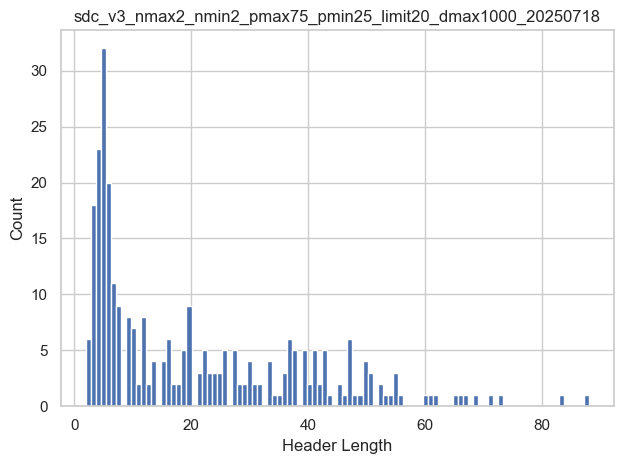

In [28]:
# # plot a bell curve of header lengths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
plt.hist(header_lengths, bins=100)
plt.xlabel('Header Length')
plt.ylabel('Count')
plt.title(f"{sdc_dir.split('/')[-1]}")
# wrap the title so it doesn't get cut off
plt.tight_layout()
# label the histogram bins with the top 5 most common header length bins
# top_5 = sorted(bin_counts.items(), key=lambda x: x[1], reverse=True)[:5]
# for i in range(0,5):
#     plt.text(top_5[i][0], top_5[i][1], str(top_5[i][1]), color='red')
# save plot to file in sdc_dir
plt.savefig(f"{sdc_dir}/{sdc_name}_header_lengths.png")



